In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
# etc.

# Load the dataset from the uploaded file
bh_data = pd.read_csv('D:/CS Classes at GT/CS 7641 - ML/ASSIGNMENT-1/boston.csv')
print(bh_data.head())
print(bh_data.info())


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-nu

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Define the features and the target
X = bh_data.drop('MEDV', axis=1).values
y = bh_data['MEDV'].values.reshape(-1, 1)  # Reshape y to be a 2D array for TensorFlow

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


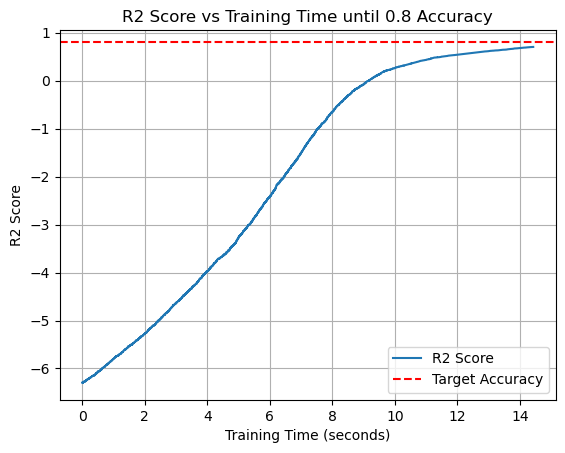

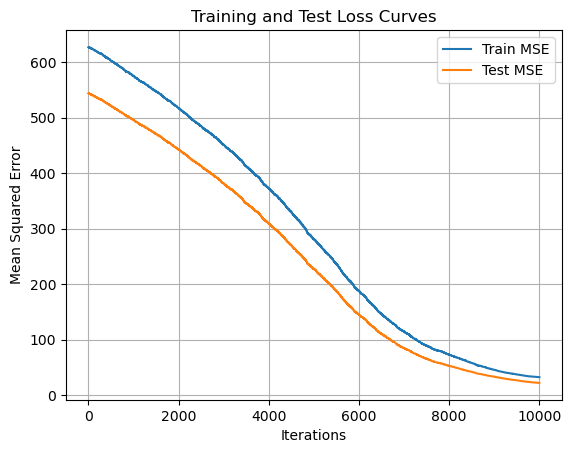

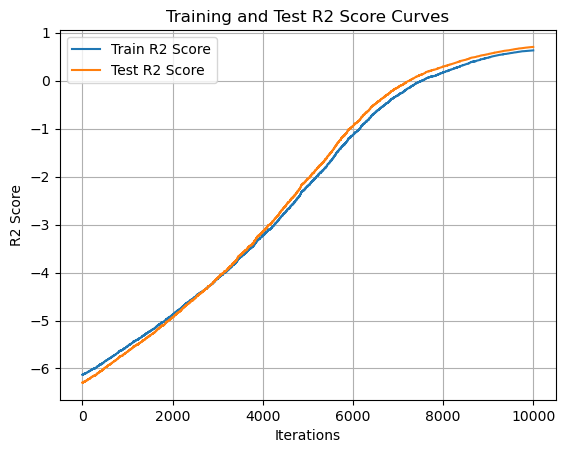

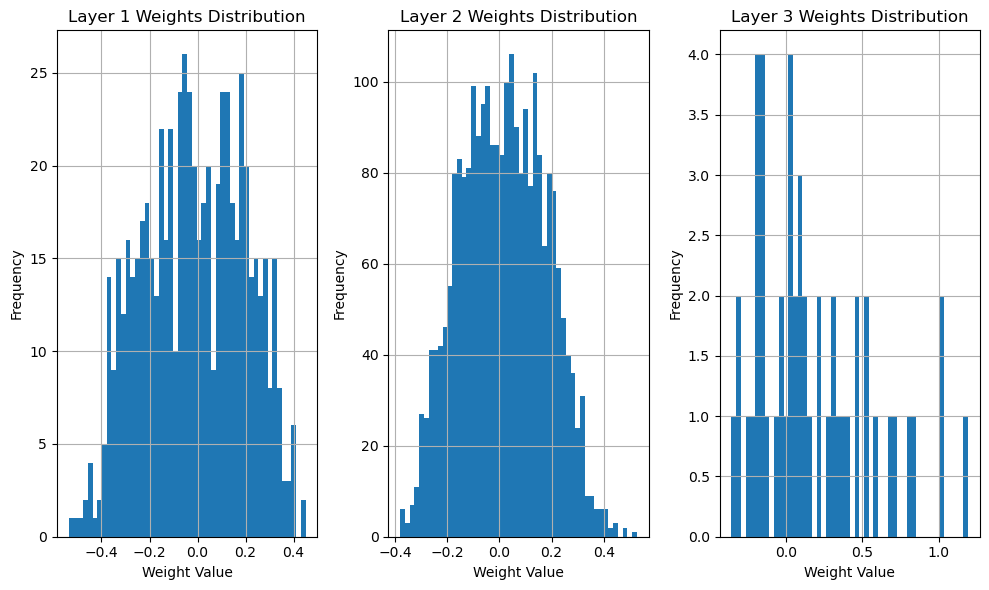

Best R2 score achieved: 0.7026306404005155
Training time until target R2 score: 14.43 seconds


In [23]:
import time
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Define the MLPRegressor with the best found parameters
mlp = MLPRegressor(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    learning_rate_init=0.001,
    max_iter=1,
    warm_start=True,
    random_state=42
)

# Initialize the model weights
mlp.fit(X_train, y_train.ravel())

# Function to perturb the weights
def perturb_weights(model, noise_level=0.001):
    new_coefs_ = [coef + noise_level * np.random.randn(*coef.shape) for coef in model.coefs_]
    new_intercepts_ = [intercept + noise_level * np.random.randn(*intercept.shape) for intercept in model.intercepts_]
    return new_coefs_, new_intercepts_

# RHC algorithm
best_score = np.inf
best_coefs = None
best_intercepts = None
mse_scores_train = []
mse_scores_test = []
r2_scores_train = []
r2_scores_test = []
target_accuracy = 0.8  # Define your target accuracy level
weights_distribution = []
cumulative_training_time = 0
training_times = []  # Store training times for each iteration
r2_scores_over_time = []  # Store R2 scores for each iteration

for i in range(10000):  # Number of iterations
    iteration_start = time.time()
    # Perturb weights and get new weights
    new_coefs, new_intercepts = perturb_weights(mlp, noise_level=0.001)
    
    # Set the new weights to the model
    mlp.coefs_ = new_coefs
    mlp.intercepts_ = new_intercepts
    
    # Evaluate performance with new weights
    predictions_train = mlp.predict(X_train)
    predictions_test = mlp.predict(X_test)
    
    mse_train = mean_squared_error(y_train, predictions_train)
    mse_test = mean_squared_error(y_test, predictions_test)
    r2_train = r2_score(y_train, predictions_train)
    r2_test = r2_score(y_test, predictions_test)
    
    mse_scores_train.append(mse_train)
    mse_scores_test.append(mse_test)
    r2_scores_train.append(r2_train)
    r2_scores_test.append(r2_test)
    
    # Update cumulative training time
    cumulative_training_time += time.time() - iteration_start
    training_times.append(cumulative_training_time)  # Store the training time
    r2_scores_over_time.append(r2_test)  # Store the R2 score for this iteration
    
    # If new score is better, update best score and weights
    if mse_test < best_score:
        best_score = mse_test
        best_coefs = new_coefs
        best_intercepts = new_intercepts
        weights_distribution = new_coefs  # Collect weights for distribution plot
    else:
        # Revert to previous best weights
        mlp.coefs_ = best_coefs
        mlp.intercepts_ = best_intercepts
    
    # Check if target accuracy is reached and stop if it is
    if r2_test >= target_accuracy:
        break

# Plotting R2 Score vs Training Time until Target Accuracy
plt.figure()
plt.plot(training_times, r2_scores_over_time, label='R2 Score')
plt.axhline(y=target_accuracy, color='r', linestyle='--', label='Target Accuracy')
plt.xlabel('Training Time (seconds)')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Training Time until 0.8 Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Loss Curves
plt.figure()
plt.plot(range(len(mse_scores_train)), mse_scores_train, label='Train MSE')
plt.plot(range(len(mse_scores_test)), mse_scores_test, label='Test MSE')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss Curves')
plt.grid(True)
plt.legend()
plt.show()

# Plotting R2 Score Curves
plt.figure()
plt.plot(range(len(r2_scores_train)), r2_scores_train, label='Train R2 Score')
plt.plot(range(len(r2_scores_test)), r2_scores_test, label='Test R2 Score')
plt.xlabel('Iterations')
plt.ylabel('R2 Score')
plt.title('Training and Test R2 Score Curves')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Weights Distribution
plt.figure(figsize=(10, 6))
for layer, weights in enumerate(weights_distribution):
    plt.subplot(1, len(weights_distribution), layer + 1)
    plt.hist(weights.flatten(), bins=50)
    plt.title(f'Layer {layer + 1} Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best R2 score achieved: {r2_scores_test[-1]}")
print(f"Training time until target R2 score: {training_times[-1]:.2f} seconds")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


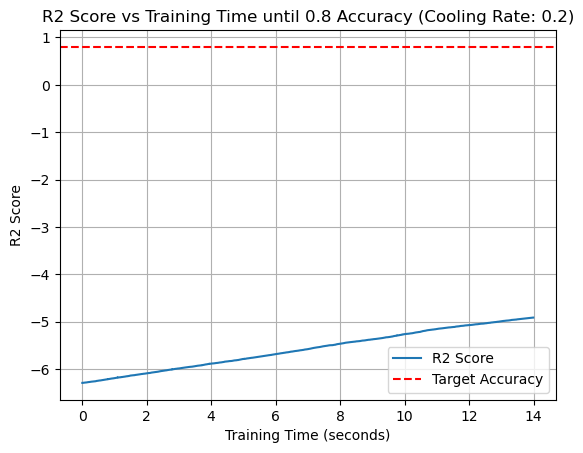

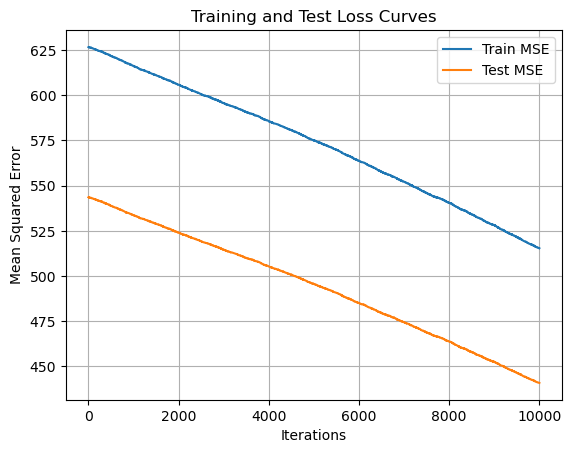

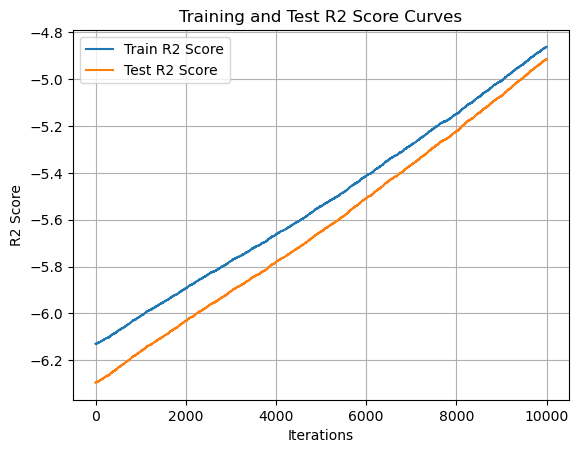

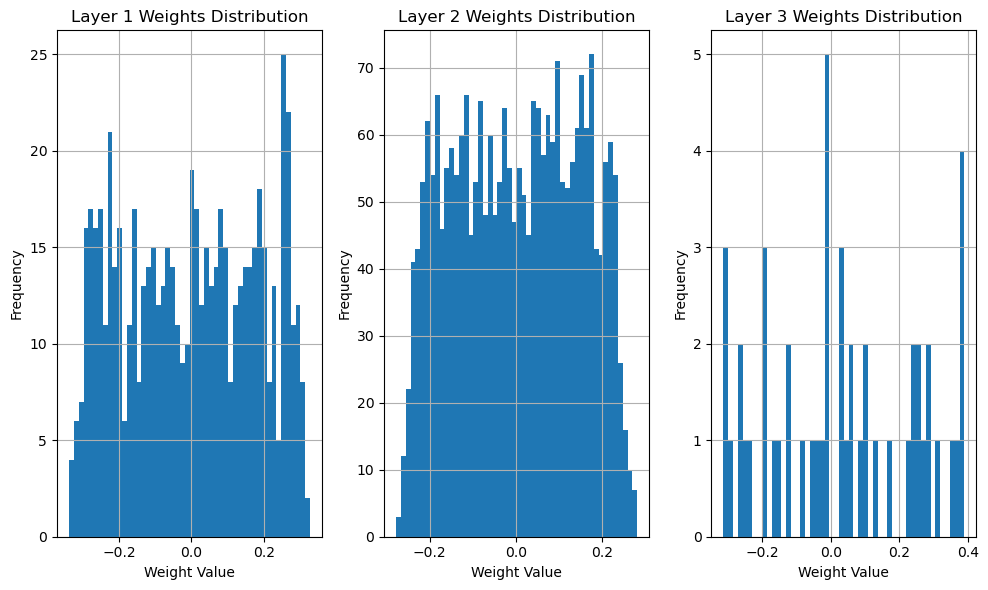

Best R2 score achieved: -4.916000522054796
Training time until target R2 score: 13.99 seconds


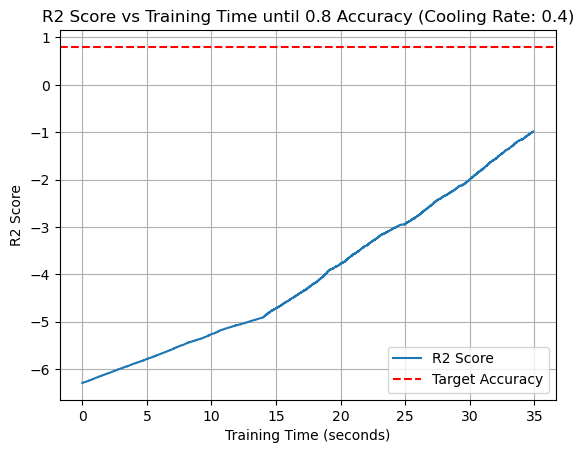

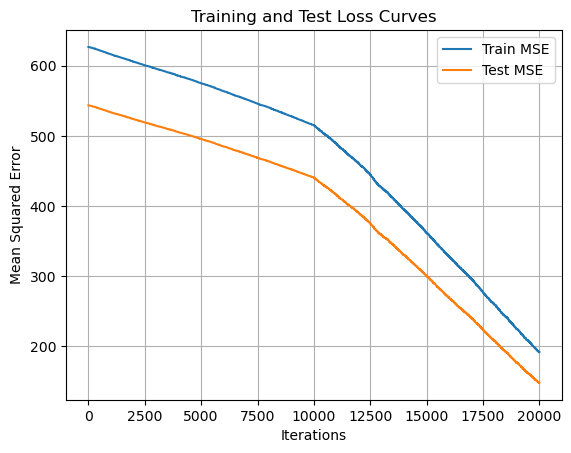

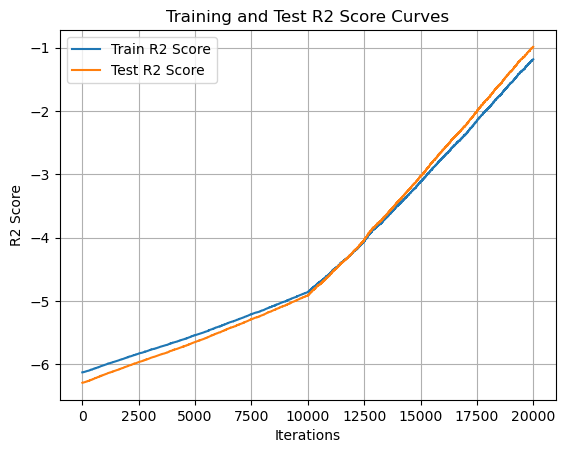

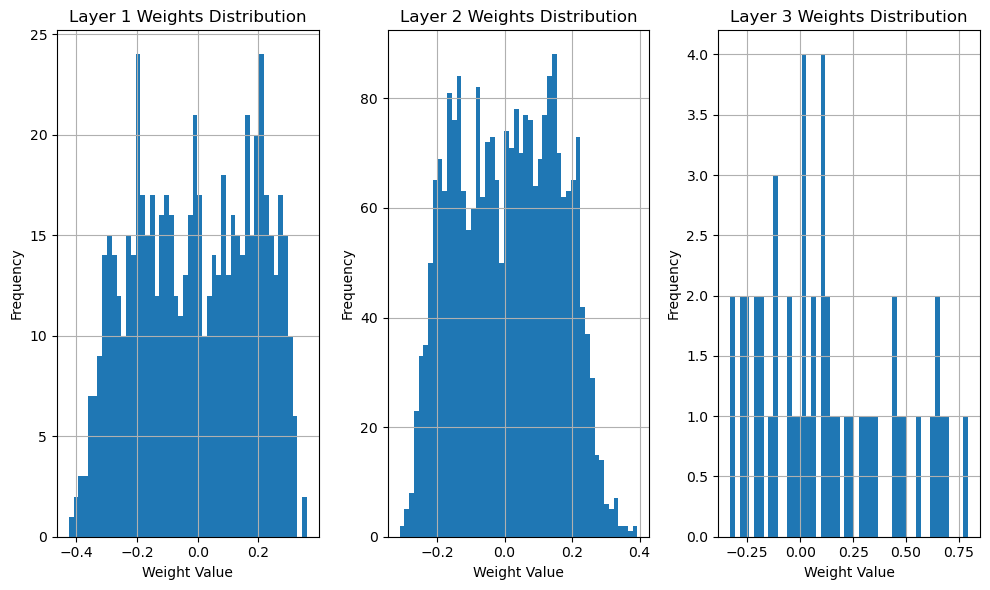

Best R2 score achieved: -0.987454798118572
Training time until target R2 score: 34.90 seconds


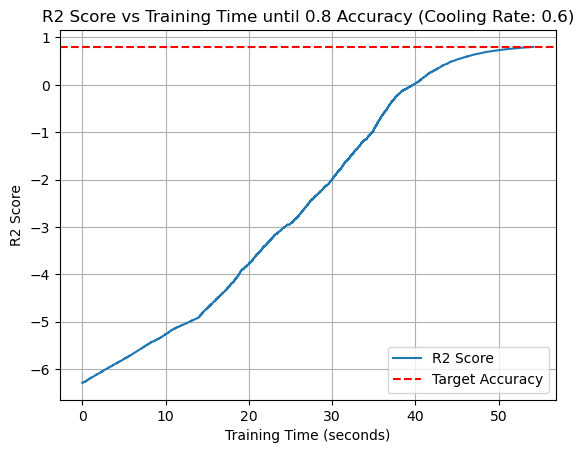

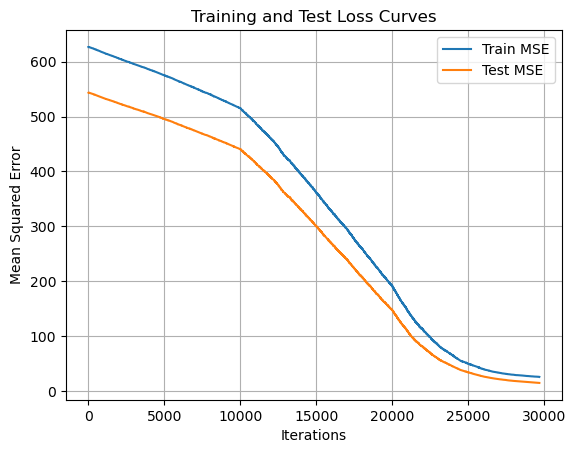

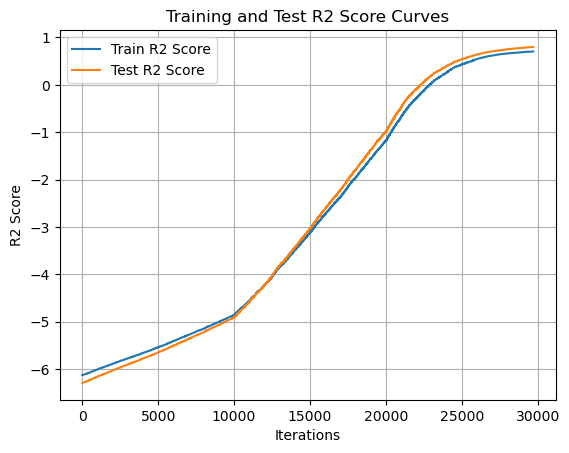

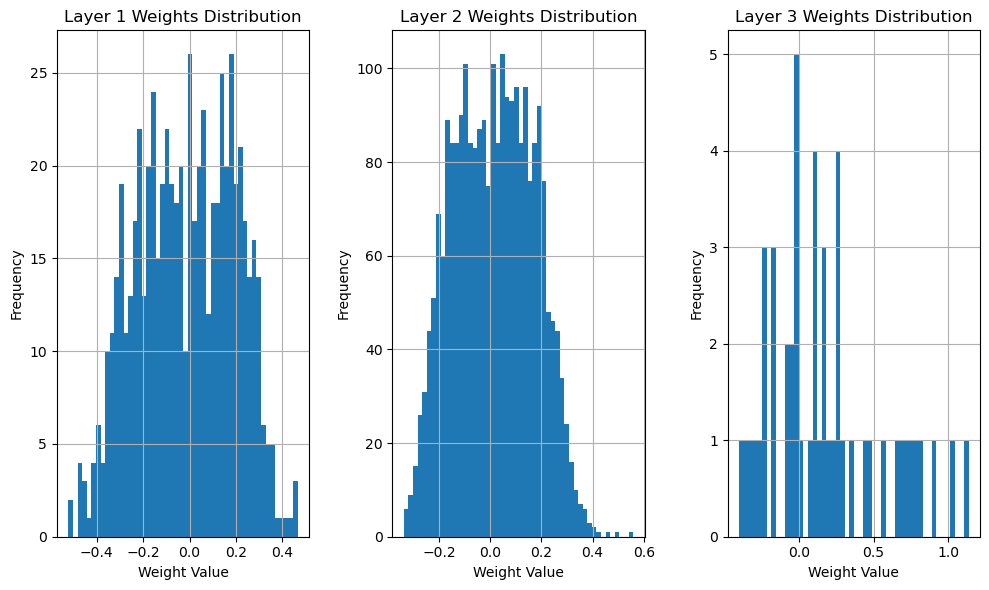

Best R2 score achieved: 0.8000271968474284
Training time until target R2 score: 54.16 seconds


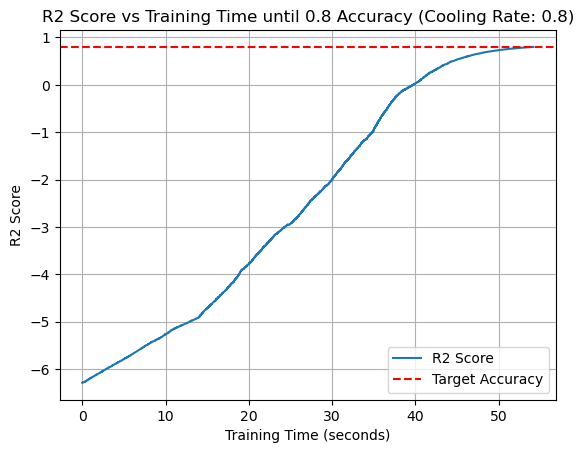

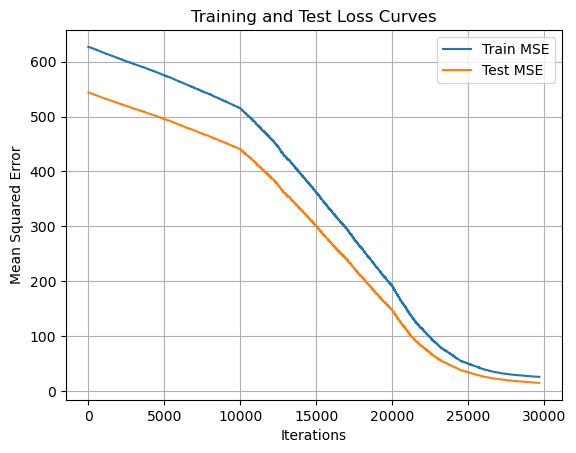

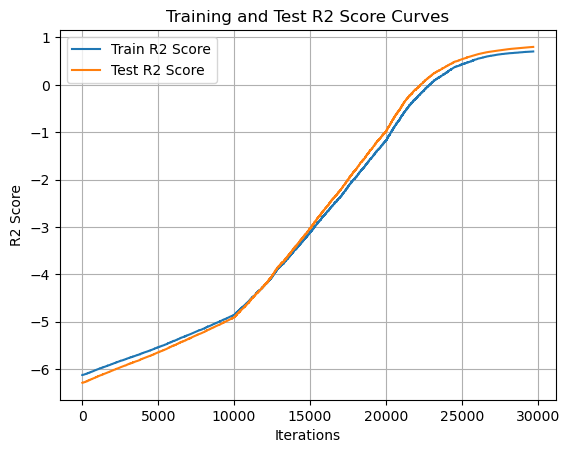

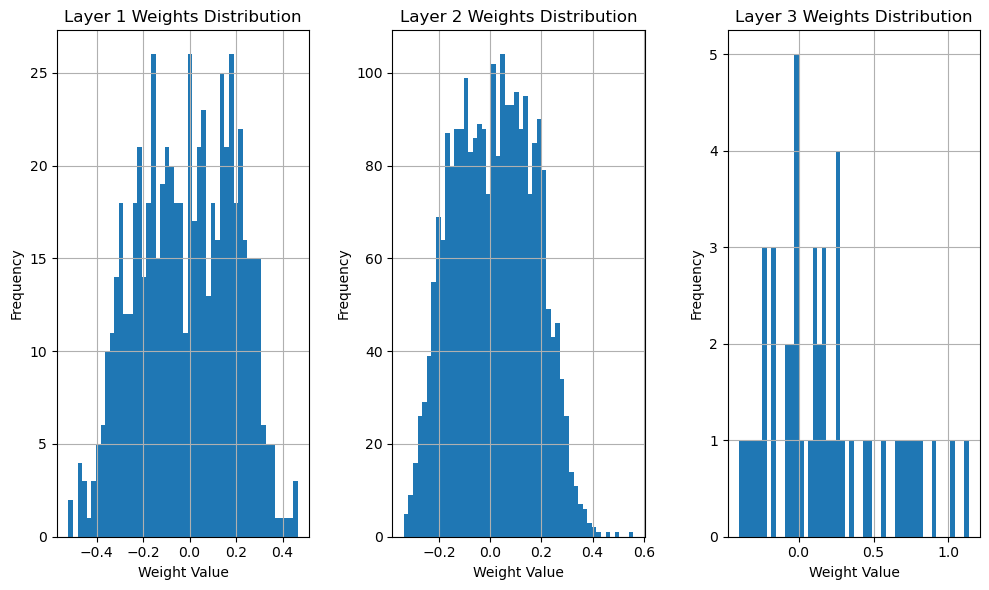

Best R2 score achieved: 0.8001280582934528
Training time until target R2 score: 54.16 seconds


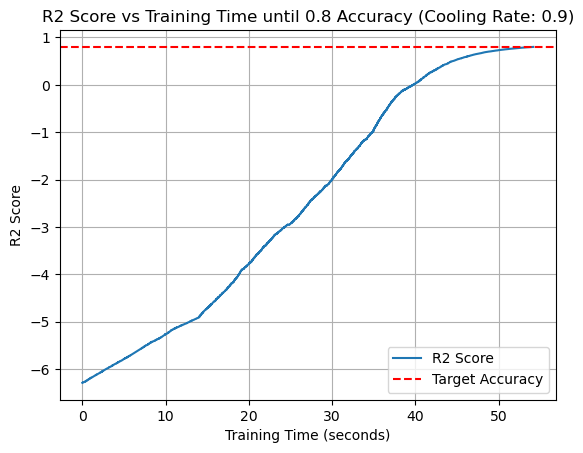

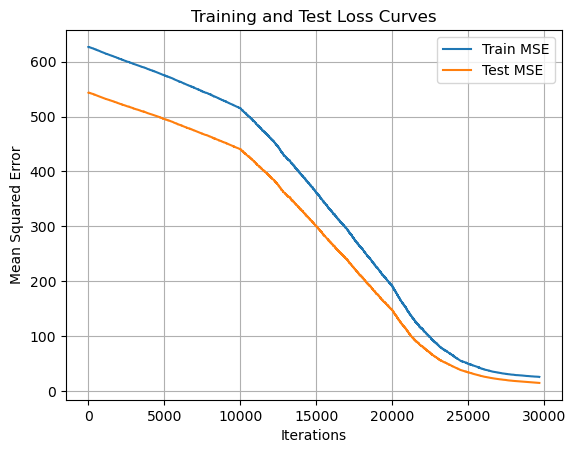

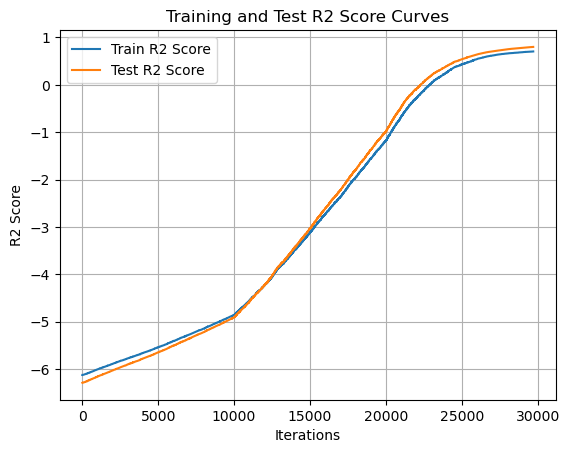

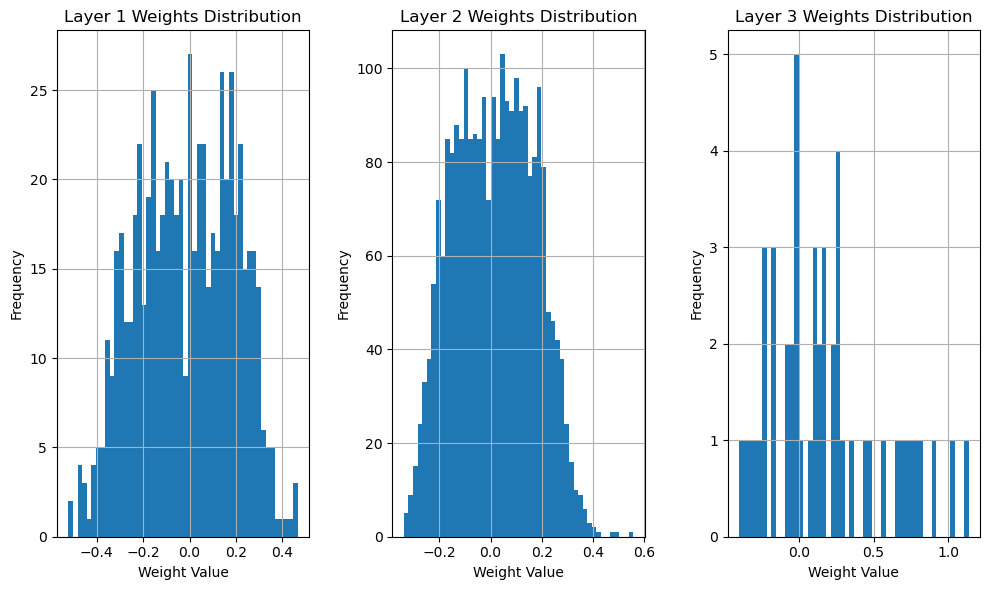

Best R2 score achieved: 0.800132525202482
Training time until target R2 score: 54.16 seconds


In [31]:
import time
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Define the MLPRegressor with the best found parameters
mlp = MLPRegressor(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    learning_rate_init=0.001,
    max_iter=1,
    warm_start=True,
    random_state=42
)

# Initialize the model weights
mlp.fit(X_train, y_train.ravel())

# Function to perturb the weights using simulated annealing
def perturb_weights(model, noise_level=0.001, temp=1.0):
    new_coefs_ = [coef + temp * noise_level * np.random.randn(*coef.shape) for coef in model.coefs_]
    new_intercepts_ = [intercept + temp * noise_level * np.random.randn(*intercept.shape) for intercept in model.intercepts_]
    return new_coefs_, new_intercepts_

# Simulated Annealing algorithm
best_score = np.inf
best_coefs = None
best_intercepts = None
mse_scores_train = []
mse_scores_test = []
r2_scores_train = []
r2_scores_test = []
target_accuracy = 0.8  # Define your target accuracy level
weights_distribution = []
cumulative_training_time = 0
training_times = []  # Store training times for each iteration
r2_scores_over_time = []  # Store R2 scores for each iteration
cooling_rates = [0.2, 0.4, 0.6, 0.8, 0.9]  # Simulated Annealing cooling rates

for temp in cooling_rates:
    for i in range(10000):  # Number of iterations
        iteration_start = time.time()
        # Perturb weights and get new weights using simulated annealing
        new_coefs, new_intercepts = perturb_weights(mlp, noise_level=0.001, temp=temp)
        
        # Set the new weights to the model
        mlp.coefs_ = new_coefs
        mlp.intercepts_ = new_intercepts
        
        # Evaluate performance with new weights
        predictions_train = mlp.predict(X_train)
        predictions_test = mlp.predict(X_test)
        
        mse_train = mean_squared_error(y_train, predictions_train)
        mse_test = mean_squared_error(y_test, predictions_test)
        r2_train = r2_score(y_train, predictions_train)
        r2_test = r2_score(y_test, predictions_test)
        
        mse_scores_train.append(mse_train)
        mse_scores_test.append(mse_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
        
        # Update cumulative training time
        cumulative_training_time += time.time() - iteration_start
        training_times.append(cumulative_training_time)  # Store the training time
        r2_scores_over_time.append(r2_test)  # Store the R2 score for this iteration
        
        # If new score is better, update best score and weights
        if mse_test < best_score:
            best_score = mse_test
            best_coefs = new_coefs
            best_intercepts = new_intercepts
            weights_distribution = new_coefs  # Collect weights for distribution plot
        else:
            # Revert to previous best weights
            mlp.coefs_ = best_coefs
            mlp.intercepts_ = best_intercepts
        
        # Check if target accuracy is reached and stop if it is
        if r2_test >= target_accuracy:
            break

    # Plotting R2 Score vs Training Time until Target Accuracy
    plt.figure()
    plt.plot(training_times, r2_scores_over_time, label='R2 Score')
    plt.axhline(y=target_accuracy, color='r', linestyle='--', label='Target Accuracy')
    plt.xlabel('Training Time (seconds)')
    plt.ylabel('R2 Score')
    plt.title(f'R2 Score vs Training Time until {target_accuracy} Accuracy (Cooling Rate: {temp})')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plotting Loss Curves
    plt.figure()
    plt.plot(range(len(mse_scores_train)), mse_scores_train, label='Train MSE')
    plt.plot(range(len(mse_scores_test)), mse_scores_test, label='Test MSE')
    plt.xlabel('Iterations')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Test Loss Curves')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plotting R2 Score Curves
    plt.figure()
    plt.plot(range(len(r2_scores_train)), r2_scores_train, label='Train R2 Score')
    plt.plot(range(len(r2_scores_test)), r2_scores_test, label='Test R2 Score')
    plt.xlabel('Iterations')
    plt.ylabel('R2 Score')
    plt.title('Training and Test R2 Score Curves')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plotting Weights Distribution
    plt.figure(figsize=(10, 6))
    for layer, weights in enumerate(weights_distribution):
        plt.subplot(1, len(weights_distribution), layer + 1)
        plt.hist(weights.flatten(), bins=50)
        plt.title(f'Layer {layer + 1} Weights Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Best R2 score achieved: {r2_scores_test[-1]}")
    print(f"Training time until target R2 score: {training_times[-1]:.2f} seconds")


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import copy

def initialize_population(pop_size):
    population = []
    for _ in range(pop_size):
        model = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', max_iter=1, warm_start=True, random_state=None)
        model.fit(X_train, y_train.ravel())
        population.append(model)
    return population

def evaluate_model(model, X_train, X_test, y_train, y_test):
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    mse_train = mean_squared_error(y_train, predictions_train)
    mse_test = mean_squared_error(y_test, predictions_test)
    r2_train = r2_score(y_train, predictions_train)
    r2_test = r2_score(y_test, predictions_test)
    return mse_train, mse_test, r2_train, r2_test

def select_parents(population, scores, num_parents):
    parents = list(np.array(population)[np.argsort(scores)[:num_parents]])
    return parents

def crossover(parents, offspring_size):
    offspring = []
    for k in range(offspring_size):
        parent1 = parents[k % len(parents)]
        parent2 = parents[(k+1) % len(parents)]
        child = copy.deepcopy(parent1)
        for i in range(len(child.coefs_)):
            child.coefs_[i] = 0.5 * (parent1.coefs_[i] + parent2.coefs_[i])
            child.intercepts_[i] = 0.5 * (parent1.intercepts_[i] + parent2.intercepts_[i])
        offspring.append(child)
    return offspring

def mutate(offspring):
    for model in offspring:
        mutation_strength = 0.1
        for i in range(len(model.coefs_)):
            mutation_matrix = np.random.randn(*model.coefs_[i].shape)
            model.coefs_[i] += mutation_strength * mutation_matrix
            mutation_vector = np.random.randn(*model.intercepts_[i].shape)
            model.intercepts_[i] += mutation_strength * mutation_vector
    return offspring

# Initialization of the tracking lists
training_times = []
average_r2_scores_per_generation = []
mse_scores_train = []
mse_scores_test = []
r2_scores_train = []
r2_scores_test = []
weights_distribution = []
target_accuracy = 0.8

ga_parameters = [[10,5,2], [20,10,5], [50,25,10], [100,50,20], [200,100,30], [500,200,50]]

for population_size, num_mutations, num_crossovers in ga_parameters:
    population = initialize_population(population_size)
    start_time = time.time()
    for generation in range(1000):  # Number of generations
        scores = []
        generation_r2_scores = []
        for model in population:
            mse_train, mse_test, r2_train, r2_test = evaluate_model(model, X_train, X_test, y_train, y_test)
            mse_scores_train.append(mse_train)
            mse_scores_test.append(mse_test)
            r2_scores_train.append(r2_train)
            generation_r2_scores.append(r2_test)
            scores.append(mse_test)
            if len(weights_distribution) < 10:
                weights_distribution.append(model.coefs_)

        average_r2_scores_per_generation.append(np.mean(generation_r2_scores))
        training_times.append(time.time() - start_time)

        parents = select_parents(population, scores, num_crossovers)
        offspring_crossover = crossover(parents, offspring_size=(population_size - len(parents)))
        offspring_mutation = mutate(offspring_crossover[:num_mutations])
        population[0:len(parents)] = parents
        population[len(parents):] = offspring_mutation

        if np.min(scores) <= mean_squared_error(y_train, np.full_like(y_train, y_train.mean())):
            break

# Plotting R2 Score vs Training Time
plt.figure()
plt.plot(training_times, average_r2_scores_per_generation, label='Average R2 Score')
plt.axhline(y=target_accuracy, color='r', linestyle='--', label='Target Accuracy')
plt.xlabel('Training Time (seconds)')
plt.ylabel('R2 Score')
plt.title('Average R2 Score vs Training Time')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Loss Curves
plt.figure()
plt.plot(mse_scores_train, label='Train MSE')
plt.plot(mse_scores_test, label='Test MSE')
plt.xlabel('Generations')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss Curves')
plt.grid(True)
plt.legend()
plt.show()

# Plotting R2 Score Curves
plt.figure()
plt.plot(r2_scores_train, label='Train R2 Score')
plt.plot(r2_scores_test, label='Test R2 Score')
plt.xlabel('Generations')
plt.ylabel('R2 Score')
plt.title('Training and Test R2 Score Curves')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Weights Distribution
plt.figure(figsize=(10, 6))
for layer, weights in enumerate(weights_distribution[0]):  # Plotting the first model's weights as an example
    plt.subplot(1, len(weights_distribution[0]), layer + 1)
    plt.hist(np.array(weights).flatten(), bins=50)
    plt.title(f'Layer {layer + 1} Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Training Time: {training_times[-1]:.2f} seconds")
print(f"Best Average R2 Score: {max(average_r2_scores_per_generation):.4f}")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y 

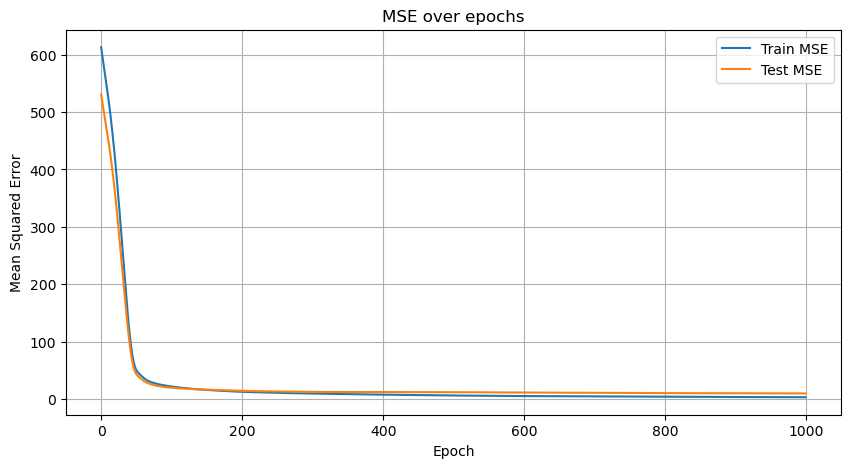

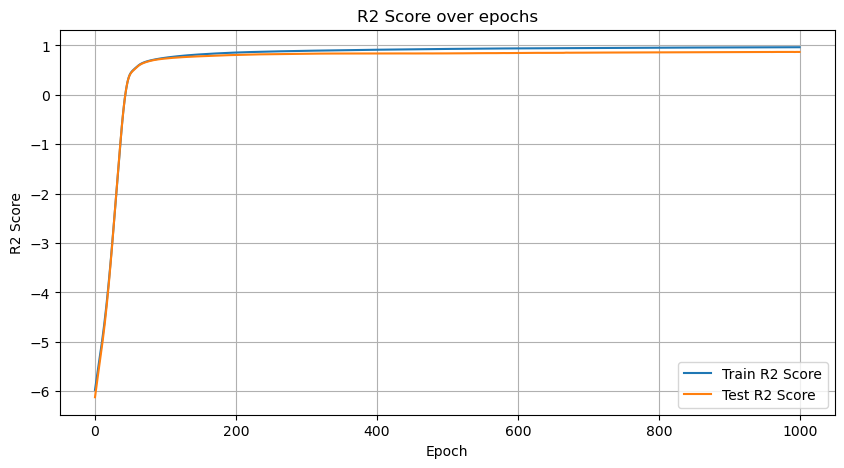

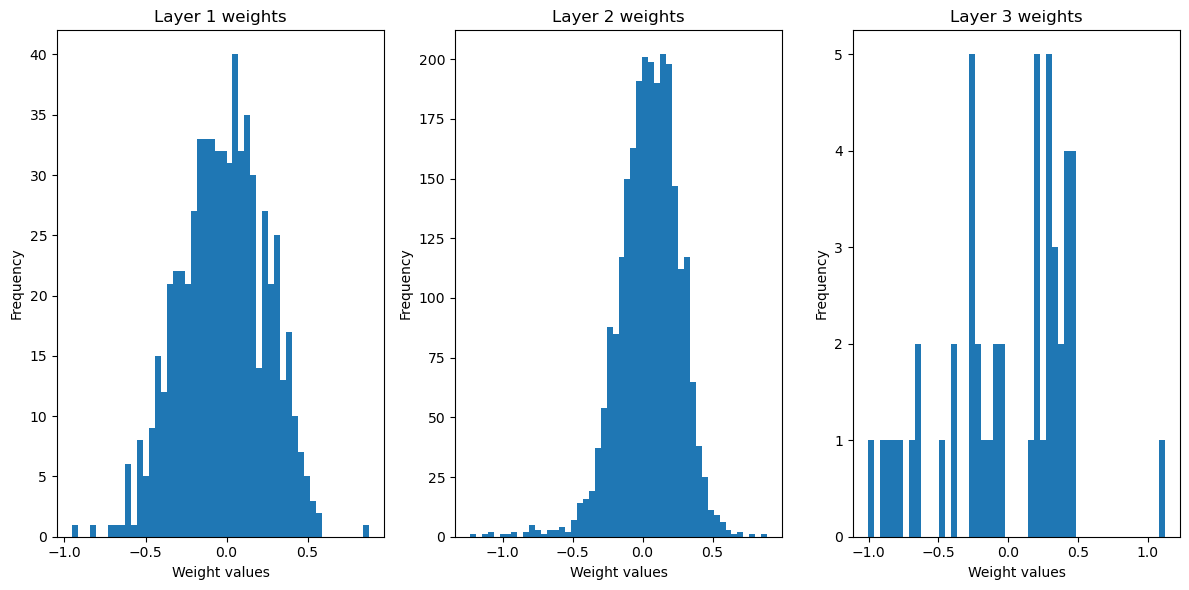

Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'max_iter': 1, 'warm_start': True}
Final Training Time: 2.49 seconds
Best Average R2 Score: 0.8698


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

# Function to train the model and collect metrics
def train_and_evaluate(X_train, y_train, X_test, y_test, params, epochs):
    model = MLPRegressor(**params)
    mse_scores_train, mse_scores_test, r2_scores_train, r2_scores_test = [], [], [], []
    weights = []
    start_time = time.time()  # Start the timer

    for epoch in range(epochs):
        model.partial_fit(X_train, y_train)  # y_train is provided at each iteration

        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)
        
        mse_scores_train.append(mean_squared_error(y_train, predictions_train))
        mse_scores_test.append(mean_squared_error(y_test, predictions_test))
        
        r2_scores_train.append(r2_score(y_train, predictions_train))
        r2_scores_test.append(r2_score(y_test, predictions_test))

        weights.append(model.coefs_)

    training_time = time.time() - start_time  # End the timer
    return model, mse_scores_train, mse_scores_test, r2_scores_train, r2_scores_test, weights, training_time

# Hyperparameters for the MLPRegressor
params = {
    'activation': 'relu',
    'hidden_layer_sizes': (50, 50),
    'learning_rate_init': 0.001,
    'max_iter': 1,  # Since we are using partial_fit
    'warm_start': True  # Keep training the same model
}

epochs = 1000  # Total number of iterations for training

# Using the preprocessed data from the first cell
model, mse_train, mse_test, r2_train, r2_test, weights, training_time = train_and_evaluate(X_train, y_train, X_test, y_test, params, epochs)

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(mse_train, label='Train MSE')
plt.plot(mse_test, label='Test MSE')
plt.title('MSE over epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and test R2 scores
plt.figure(figsize=(10, 5))
plt.plot(r2_train, label='Train R2 Score')
plt.plot(r2_test, label='Test R2 Score')
plt.title('R2 Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the distribution of the weights after training
final_weights = weights[-1]  # Get the weights of the last epoch
plt.figure(figsize=(12, 6))
for i, layer_weights in enumerate(final_weights):
    plt.subplot(1, len(final_weights), i + 1)
    plt.hist(np.hstack(layer_weights), bins=50)
    plt.title(f'Layer {i+1} weights')
    plt.xlabel('Weight values')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Output the final results
print(f"Parameters: {params}")
print(f"Final Training Time: {training_time:.2f} seconds")
print(f"Best Average R2 Score: {max(r2_test):.4f}")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_m

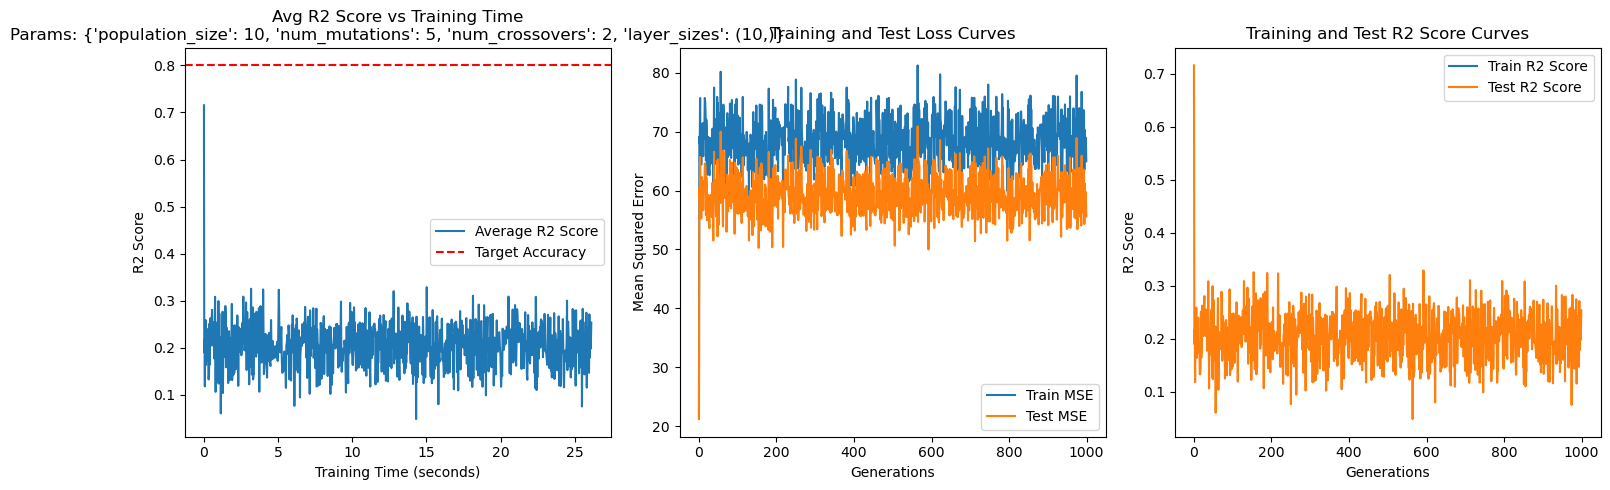

Parameters: {'population_size': 10, 'num_mutations': 5, 'num_crossovers': 2, 'layer_sizes': (10,)}
Final Training Time: 26.12 seconds
Best Average R2 Score: 0.7153


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_m

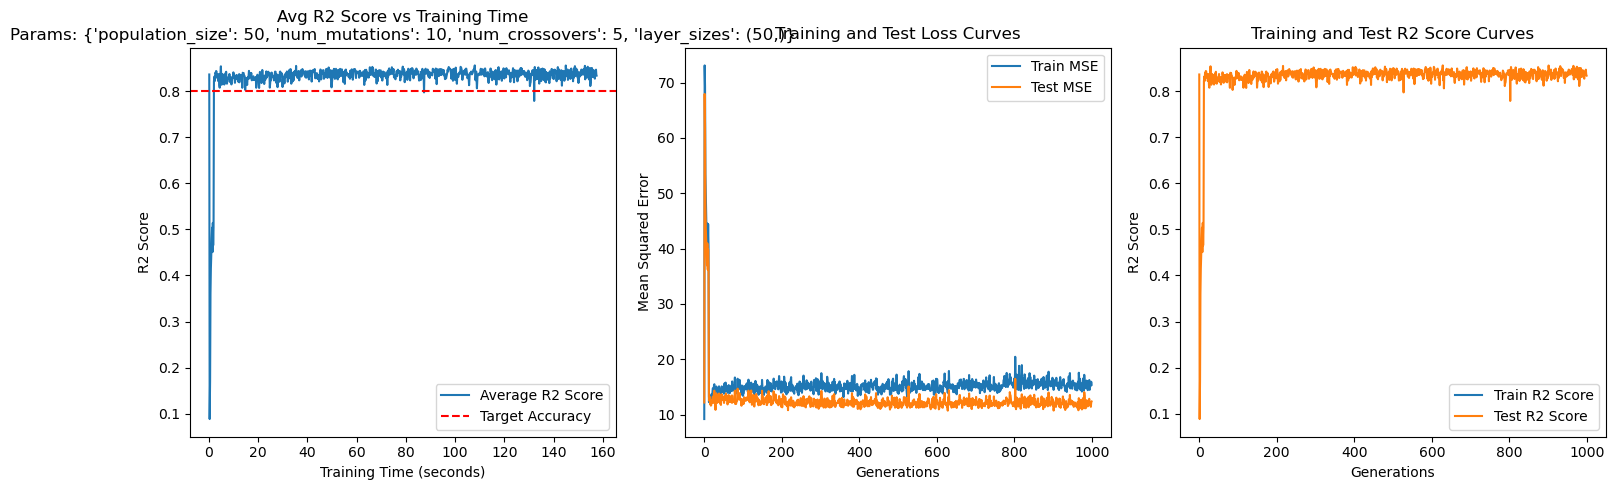

Parameters: {'population_size': 50, 'num_mutations': 10, 'num_crossovers': 5, 'layer_sizes': (50,)}
Final Training Time: 157.47 seconds
Best Average R2 Score: 0.8563


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_m

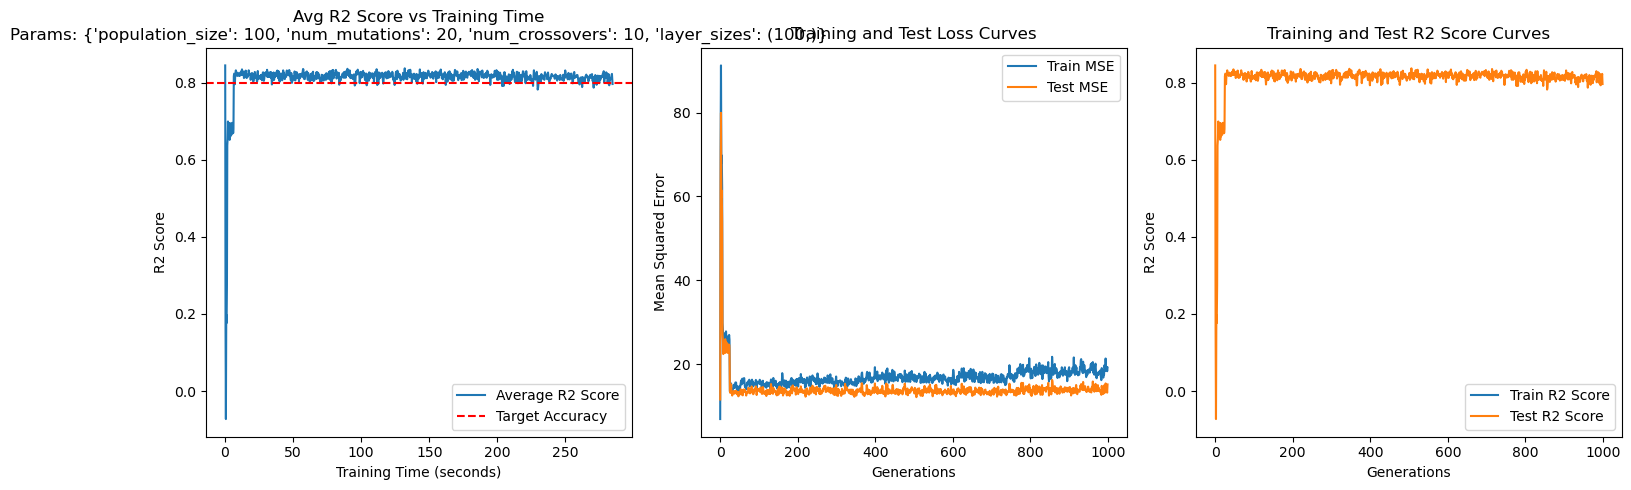

Parameters: {'population_size': 100, 'num_mutations': 20, 'num_crossovers': 10, 'layer_sizes': (100,)}
Final Training Time: 284.55 seconds
Best Average R2 Score: 0.8449


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_m

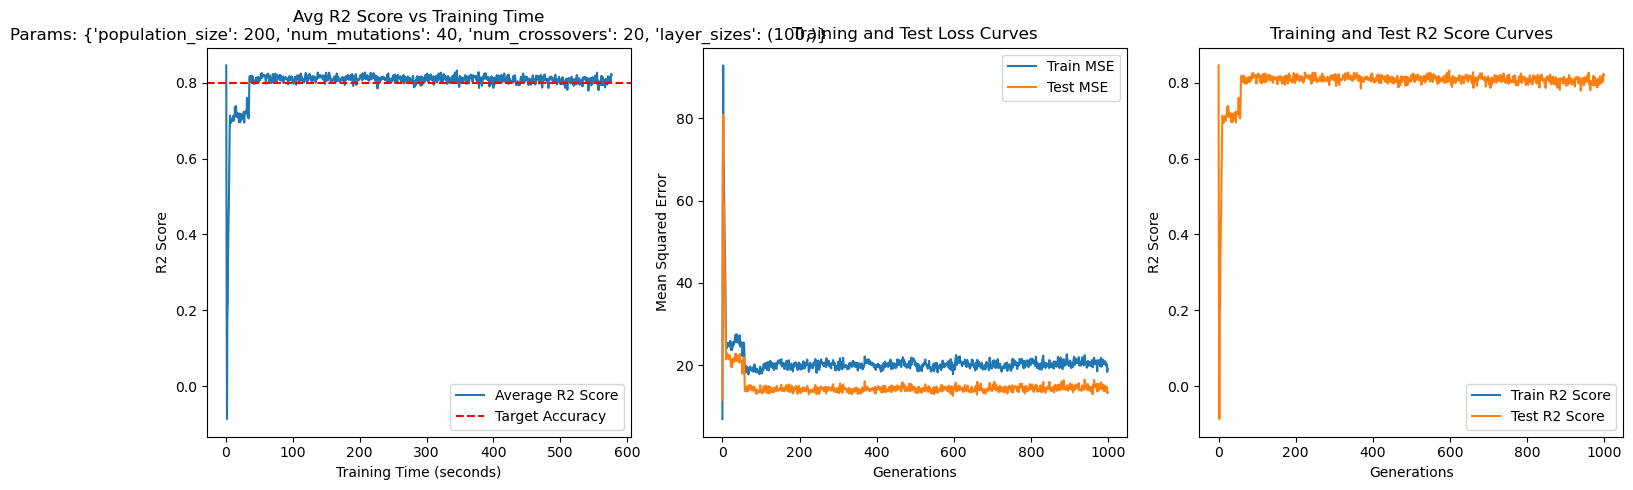

Parameters: {'population_size': 200, 'num_mutations': 40, 'num_crossovers': 20, 'layer_sizes': (100,)}
Final Training Time: 576.65 seconds
Best Average R2 Score: 0.8452


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_m

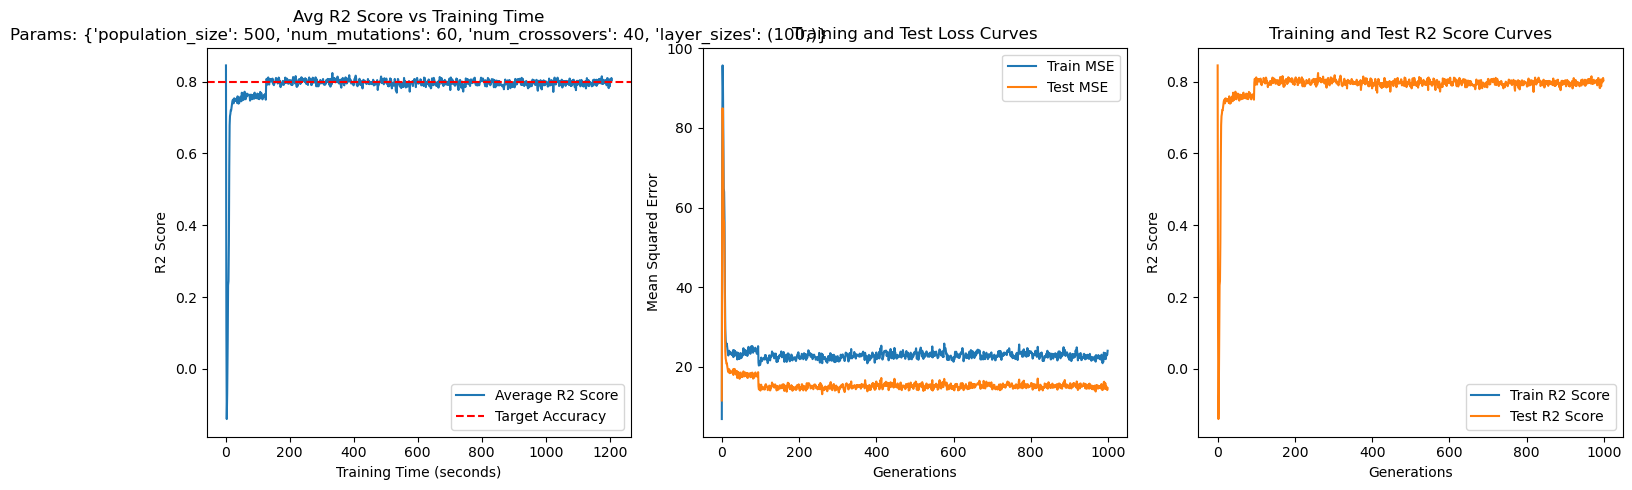

Parameters: {'population_size': 500, 'num_mutations': 60, 'num_crossovers': 40, 'layer_sizes': (100,)}
Final Training Time: 1206.45 seconds
Best Average R2 Score: 0.8453


In [94]:
http://localhost:8888/notebooks/ML-%20ASSIGNMENT%202%20-%20BOSTON%20HOUSING%20-%20NEURAL%20NETWORK%20-%20Local%20Random%20Search%20Algorithms.ipynb#import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import copy
import time

# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize population of neural network models with variable architectures
def initialize_population(pop_size, layer_sizes, X_train, y_train):
    population = []
    for _ in range(pop_size):
        model = MLPRegressor(hidden_layer_sizes=layer_sizes, activation='relu', solver='adam', max_iter=1000)
        model.fit(X_train, y_train.ravel())
        population.append(model)
    return population

# Evaluate the model and get MSE and R2 scores
def evaluate_model(model, X_train, X_test, y_train, y_test):
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    mse_train = mean_squared_error(y_train, predictions_train)
    mse_test = mean_squared_error(y_test, predictions_test)
    r2_train = r2_score(y_train, predictions_train)
    r2_test = r2_score(y_test, predictions_test)
    return mse_train, mse_test, r2_train, r2_test

def select_parents(population, scores, num_parents):
    # Sort the scores and return the indices of the best individuals
    sorted_parent_indices = np.argsort(scores)[:num_parents]
    parents = [population[idx] for idx in sorted_parent_indices]
    return parents

def crossover(parents, offspring_size):
    offspring = []
    for k in range(offspring_size):
        parent1 = parents[k % len(parents)]
        parent2 = parents[(k + 1) % len(parents)]
        child = copy.deepcopy(parent1)
        for i in range(len(child.coefs_)):
            child.coefs_[i] = 0.5 * (parent1.coefs_[i] + parent2.coefs_[i])
            child.intercepts_[i] = 0.5 * (parent1.intercepts_[i] + parent2.intercepts_[i])
        offspring.append(child)
    return offspring

def mutate(offspring, mutation_strength=0.1):
    for model in offspring:
        for i in range(len(model.coefs_)):
            mutation_matrix = np.random.randn(*model.coefs_[i].shape)
            model.coefs_[i] += mutation_strength * mutation_matrix
            mutation_vector = np.random.randn(*model.intercepts_[i].shape)
            model.intercepts_[i] += mutation_strength * mutation_vector
    return offspring

# Define your genetic algorithm parameters
ga_parameters = [
    {'population_size': 10, 'num_mutations': 5, 'num_crossovers': 2, 'layer_sizes': (10,)},
    {'population_size': 50, 'num_mutations': 10, 'num_crossovers': 5, 'layer_sizes': (50,)},
    {'population_size': 100, 'num_mutations': 20, 'num_crossovers': 10, 'layer_sizes': (100,)},
    {'population_size': 200, 'num_mutations': 40, 'num_crossovers': 20, 'layer_sizes': (100,)},
    {'population_size': 500, 'num_mutations': 60, 'num_crossovers': 40, 'layer_sizes': (100,)},
]

# Genetic Algorithm Implementation
for param_set in ga_parameters:
    population_size = param_set['population_size']
    num_mutations = param_set['num_mutations']
    num_crossovers = param_set['num_crossovers']
    layer_sizes = param_set['layer_sizes']
    
    # Initialize the population
    population = initialize_population(population_size, layer_sizes, X_train_scaled, y_train)

    # Metrics storage
    metrics = {'mse_train': [], 'mse_test': [], 'r2_train': [], 'r2_test': []}
    average_r2_scores_per_generation = []
    training_times = []
    
    start_time = time.time()
    for generation in range(1000):  # Number of generations
        # Evaluate the current generation
        generation_metrics = {'mse_train': [], 'mse_test': [], 'r2_train': [], 'r2_test': []}
        for model in population:
            mse_train, mse_test, r2_train, r2_test = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
            generation_metrics['mse_train'].append(mse_train)
            generation_metrics['mse_test'].append(mse_test)
            generation_metrics['r2_train'].append(r2_train)
            generation_metrics['r2_test'].append(r2_test)
        
        # Metrics for the generation
        metrics['mse_train'].append(generation_metrics['mse_train'])
        metrics['mse_test'].append(generation_metrics['mse_test'])
        metrics['r2_test'].append(generation_metrics['r2_test'])
        average_r2_scores_per_generation.append(np.mean(generation_metrics['r2_test']))
        
        # Cumulative training time
        training_times.append(time.time() - start_time)

        # Genetic Algorithm operations
        mse_scores = generation_metrics['mse_test']
        parents = select_parents(population, mse_scores, num_crossovers)
        
        # Elitism: Keep the best models as they are
        elite = copy.deepcopy(parents[:2])  # Keeping 2 best models unchanged
        
        offspring_crossover = crossover(parents, offspring_size=(population_size - len(parents)))
        offspring_mutation = mutate(offspring_crossover[:num_mutations])

        # New generation: elite + mutated offspring
        population[:len(elite)] = elite
        population[len(elite):len(parents)] = offspring_crossover[:len(parents) - len(elite)]
        population[len(parents):] = offspring_mutation

    # End of GA loop

    # Final metrics and plotting
    final_training_time = training_times[-1]
    best_average_r2_score = max(average_r2_scores_per_generation)
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(training_times, average_r2_scores_per_generation, label='Average R2 Score')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target Accuracy')
    plt.xlabel('Training Time (seconds)')
    plt.ylabel('R2 Score')
    plt.title(f'Avg R2 Score vs Training Time\nParams: {param_set}')
    plt.legend()

    plt.subplot(1, 3, 2)
    train_mse_means = [np.mean(gen) for gen in metrics['mse_train']]
    test_mse_means = [np.mean(gen) for gen in metrics['mse_test']]
    plt.plot(train_mse_means, label='Train MSE')
    plt.plot(test_mse_means, label='Test MSE')
    plt.xlabel('Generations')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Test Loss Curves')
    plt.legend()

    plt.subplot(1, 3, 3)
    train_r2_means = [np.mean(gen) for gen in metrics['r2_train']]
    test_r2_means = [np.mean(gen) for gen in metrics['r2_test']]
    plt.plot(train_r2_means, label='Train R2 Score')
    plt.plot(test_r2_means, label='Test R2 Score')
    plt.xlabel('Generations')
    plt.ylabel('R2 Score')
    plt.title('Training and Test R2 Score Curves')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Parameters: {param_set}")
    print(f"Final Training Time: {final_training_time:.2f} seconds")
    print(f"Best Average R2 Score: {best_average_r2_score:.4f}")